In [1]:
from pandas_gbq import read_gbq
import matplotlib.pyplot as plt
from tableone import TableOne
from pathlib import Path
import seaborn as sns
import pandas as pd
import numpy as np
import os

In [2]:
PROCEDURES=Path("./procedures")
PROJECT_ID=os.getenv("clinical-entity-extraction") 
# Pass a project-id to a Google Cloud Project.
# Make sure that your google account associated to the google cloud project is the same authorized to access eICU


In [3]:
query=open(PROCEDURES / "transfusion.sql","r").read()
transfusion_df=read_gbq(query,project_id="clinical-entity-extraction")
transfusion_df

Downloading: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████|


,patientunitstayid,itemid,offset,item,value,unit
0,189267,12668554,300,Volume-Transfuse red blood cells,62.00,ml
1,181209,14907770,15218,Volume-Transfuse red blood cells,200.00,ml
2,214763,13872407,415,Volume-Transfuse red blood cells,200.00,ml
3,200629,11165621,-711,Volume-Transfuse red blood cells,232.00,ml
4,156977,13350292,-10,Volume-Transfuse red blood cells,256.00,ml
...,...,...,...,...,...,...
5836,165770,13633978,11796,Volume-Transfuse red blood cells,243.33,ml
5837,148020,13961427,5570,Volume-Transfuse red blood cells,333.80,ml
5838,232142,14110996,34493,Volume-Transfuse red blood cells,289.33,ml
5839,152775,12681747,-2910,Volume-Transfuse red blood cells,361.33,ml


In [4]:
query=open(PROCEDURES / "hgb.sql","r").read()
hgb_df=read_gbq(query,project_id=PROJECT_ID)
hgb_df

Downloading: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████|


,patientunitstayid,itemid,offset,item,value,unit
0,674212,169748465,-80,Hgb,NaN,g/dL
1,1061601,254959493,-203,Hgb,NaN,g/dL
2,1060522,254236558,-229,Hgb,NaN,g/dL
3,1070258,253718933,-173,Hgb,NaN,g/dL
4,2753696,652952551,-124,Hgb,4.0,g/dL
...,...,...,...,...,...,...
1298703,711002,166249598,-145,Hgb,16.8,g/dL
1298704,996449,246290059,-549,Hgb,17.8,g/dL
1298705,200319,50419619,-205,Hgb,17.8,g/dL
1298706,1653398,406317309,-99,Hgb,18.8,g/dL


In [5]:
query=open(PROCEDURES / "blood_loss.sql","r").read()
blood_loss_df=read_gbq(query,project_id=PROJECT_ID)
blood_loss_df

Downloading: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████|


,patientunitstayid,itemid,offset,item,value,unit
0,3003577,180157539,1863,Blood Loss,0.0,ml
1,3008718,180862463,3942,Blood Loss,0.0,ml
2,3030607,180849675,998,Blood Loss,0.0,ml
3,1587796,119044588,26816,Blood Loss,0.0,ml
4,3004557,180544957,2229,Blood Loss,0.0,ml
...,...,...,...,...,...,...
14565,197471,13408048,15982,Blood Loss,200.0,ml
14566,169913,16476948,1865,Blood Loss,200.0,ml
14567,233353,14086837,2417,Blood Loss,200.0,ml
14568,240586,9522851,28064,Blood Loss,1.0,ml


In [6]:
ids=transfusion_df['patientunitstayid'].drop_duplicates() # unique ids for all patients to be included
ids=np.array(ids)
# filter any df to only keep patients to be in the study
def filter_ids(df, ids=ids):
    return df[df['patientunitstayid'].isin(ids)]

In [7]:
query=open(PROCEDURES / "apache.sql","r").read()
apache=read_gbq(query,project_id=PROJECT_ID)
apache=filter_ids(apache)
# dropping duplicated patients with multiple apache_score for each apache_version
apache=apache.drop_duplicates(subset='patientunitstayid', keep='first')
apache

Downloading: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████|


,apacheID,patientunitstayid,apache_score,apache_version,pred_mortality,actual_mortality
10,47819,141233,66,IVa,0.035490,ALIVE
18,138144,141266,44,IVa,0.040574,ALIVE
32,42515,141304,67,IV,0.149145,ALIVE
52,122208,141392,35,IVa,0.021379,ALIVE
74,31902,141518,42,IVa,0.026247,ALIVE
...,...,...,...,...,...,...
20548,63741,241726,34,IV,0.037069,ALIVE
20558,26560,241775,103,IV,0.504141,ALIVE
20562,31863,241785,56,IV,0.118066,ALIVE
20564,42498,241787,73,IVa,0.116634,EXPIRED


In [8]:
query=open(PROCEDURES / "demographics.sql","r").read()
demographics=read_gbq(query,project_id=PROJECT_ID)
demographics=filter_ids(demographics)
demographics['age'] = pd.to_numeric(demographics['age'], errors='coerce')
demographics

Downloading: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████|


,patientunitstayid,age,gender,ethnicity,initial_weight
10,141233,81.0,Female,Caucasian,61.7
16,141266,73.0,Male,Caucasian,120.4
23,141304,70.0,Male,Caucasian,NaN
34,141392,78.0,Female,Caucasian,NaN
47,141518,85.0,Female,Caucasian,55.3
...,...,...,...,...,...
14933,241726,75.0,Female,Caucasian,NaN
14938,241775,44.0,Female,Caucasian,45.4
14945,241785,77.0,Female,Caucasian,75.3
14947,241787,61.0,Male,Caucasian,95.5


In [9]:
demographics.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2098 entries, 10 to 14956
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   patientunitstayid  2098 non-null   Int64  
 1   age                2018 non-null   float64
 2   gender             2098 non-null   object 
 3   ethnicity          2098 non-null   object 
 4   initial_weight     1588 non-null   float64
dtypes: Int64(1), float64(2), object(2)
memory usage: 100.4+ KB


In [10]:
demog_columns = demographics.columns
demog_categorical=['gender']
demog_nonnormal=['patientunitstayid', 'age']

demog_table = TableOne(demographics,
                       columns=list(demog_columns),
                       categorical=demog_categorical,
                       nonnormal=demog_nonnormal,
                       groupby='ethnicity')

In [11]:
demog_table

Grouped by ethnicity                                                                                                                                                                                                                                                
                                                      Missing                       Overall                                            African American                         Asian                     Caucasian                      Hispanic               Native American                 Other/Unknown
n                                                          26                            26                            26                           240                            41                          1652                           120                            15                             4
patientunitstayid, median [Q1,Q3]                           0  192690.5 [166067.5,217377.5]  195878.5 [173739.0,210616.8]  193057.5 [163286.0,220422.8]  181038.0 [163580.0,208303.0]  191943.5 [166352.5,216401.0]  195659.0 [170274.0,221130.2]  190696.0 [156271.0,210013.5]  217268.5 [205050.5,228976.8]
age, median [Q1,Q3]                                        80              67.0 [56.0,77.0]              58.0 [54.0,79.0]              59.0 [51.0,69.0]              63.0 [43.2,70.0]              69.0 [60.0,78.0]              52.0 [41.0,63.5]              56.0 [55.5,66.5]              62.0 [53.0,73.5]
gender, n (%)                     Female                                        1017 (48.5)                     13 (50.0)                    128 (53.3)                     20 (48.8)                    792 (47.9)                     60 (50.0)                      3 (20.0)                      1 (25.0)
                                  Male                                          1081 (51.5)                     13 (50.0)                    112 (46.7)                     21 (51.2)                    860 (52.1)                     60 (50.0)                     12 (80.0)                      3 (75.0)
initial_weight, mean (SD)                                 510                   82.4 (29.7)                   79.6 (24.2)                   85.3 (31.3)                   56.1 (11.8)                   83.0 (30.2)                   76.8 (20.0)                   94.5 (17.7)                   61.6 (11.8)

*Testing extracting for one hour before*

In [12]:
# window_size (minutes): interval to use when looking for offset values 
# x_id: the order of the patientunitstayid in the 'ids' array 

def readings_avg(window_size, x_id):
    id = ids[x_id]
    
    hgb_read = hgb_df[hgb_df['patientunitstayid'] == id]
    transfusion = transfusion_df[transfusion_df['patientunitstayid'] == id]
    
    hgb_read = hgb_read.sort_values(by=['offset'])
    transfusion = transfusion.sort_values(by=['offset'])
    
    # Find the first transfusion offset greater than or equal to window_size
    transfusion_offset = transfusion[transfusion['offset'] >= window_size]
    
    if transfusion_offset.empty:
        return

    transfusion_offset = transfusion_offset['offset'].tolist()[0]  
    
    result = hgb_read[(hgb_read['offset'] >= transfusion_offset - window_size) 
                    & (hgb_read['offset'] <= transfusion_offset + window_size)]
    
    if result.empty:
        # no hgb readings in the window
        hgb_before = np.nan
        hgb_after = np.nan
    else:
        hgb_before = result[result['offset'] <= transfusion_offset]
        hgb_before = np.mean(hgb_before['value'].tolist()) if not hgb_before.empty else np.nan
        
        hgb_after = result[result['offset'] > transfusion_offset]
        hgb_after = np.mean(hgb_after['value'].tolist()) if not hgb_after.empty else np.nan
    
    avg_hgb_readings.loc[avg_hgb_readings.shape[0]] = [ids[x_id], hgb_before, hgb_after, window_size, transfusion_offset]


In [14]:
avg_hgb_readings=pd.DataFrame(columns=['patientunitstayid', 'hgb_before', 'hgb_after', 'window_size', 'transfusion_offset'])
# try using different window_size. Try testing window on same patients and different patients (change loop range)

# may use joblib if needed
for i in range(1500):
    readings_avg(500, i)

for i in range(1500):
    readings_avg(1100, i)

for i in range(1500):
    readings_avg(1700, i)

In [15]:
avg_hgb_readings.shape

(3298, 5)

In [16]:
hgb_cols = ['hgb_before', 'hgb_after', 'window_size', 'transfusion_offset']
hgb_nonnormal=['hgb_before', 'hgb_after']

hgb_tableone = TableOne(avg_hgb_readings,
                       columns=list(hgb_cols),
                       nonnormal=hgb_nonnormal,
                       groupby='window_size')

In [17]:
hgb_tableone

Grouped by window_size                                                                    
                                              Missing          Overall           1100.0           1700.0            500.0
n                                                                 3298             1095              951             1252
hgb_before, median [Q1,Q3]                        499    7.4 [6.8,7.9]    7.5 [6.9,8.0]    7.5 [7.0,8.0]    7.2 [6.6,7.8]
hgb_after, median [Q1,Q3]                         559    8.8 [8.1,9.6]    8.8 [8.1,9.7]    8.9 [8.1,9.6]    8.7 [8.0,9.4]
transfusion_offset, mean (SD)                       0  4985.7 (6217.9)  5001.2 (6114.8)  6186.6 (6639.3)  4059.9 (5810.9)

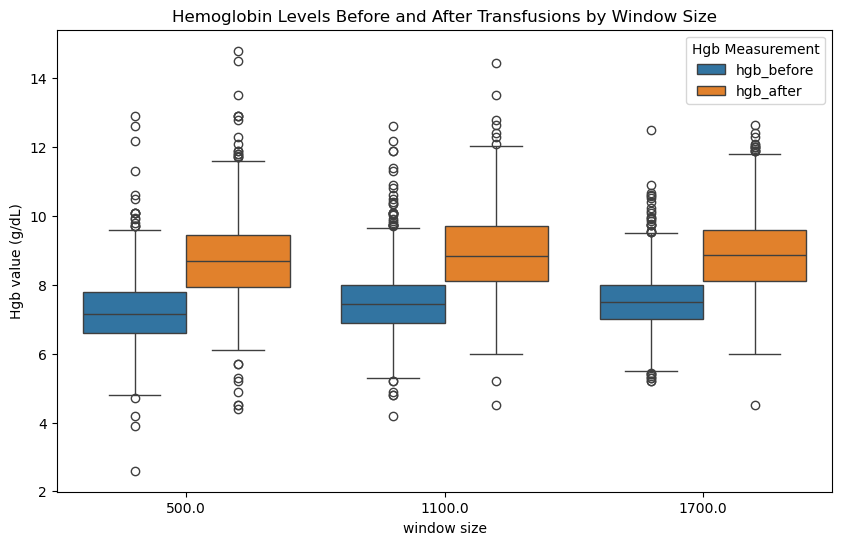

In [18]:
hgb_before = avg_hgb_readings['hgb_before']
hgb_after = avg_hgb_readings['hgb_after']
window_size = avg_hgb_readings['window_size']

df_melt = pd.melt(avg_hgb_readings, id_vars='window_size', value_vars=['hgb_before', 'hgb_after'], 
                  var_name='Hgb Type', value_name='Hgb Value')

plt.figure(figsize=(10, 6))
sns.boxplot(df_melt, x='window_size', y='Hgb Value', hue='Hgb Type')

plt.title('Hemoglobin Levels Before and After Transfusions by Window Size')
plt.xlabel('window size')
plt.ylabel('Hgb value (g/dL)')
plt.legend(title='Hgb Measurement')

plt.show()


In [19]:
# Find the average difference in time between the first two HGB readings for every patient

time_diff=np.array([])
for id in ids:
    # hgb readings for patient
    hgb_read=hgb_df[hgb_df['patientunitstayid']==id]
    hgb_read=hgb_read.sort_values(by=['offset'])

    try:
        time_diff =np.insert(time_diff, 0, hgb_read.iloc[1, 2]-hgb_read.iloc[0, 2])
    except:
        pass

In [20]:
print('avg time diff:', time_diff.mean())
print('avg time std:', time_diff.std())

avg time diff: 1159.9148112294288
avg time std: 9210.113494065932


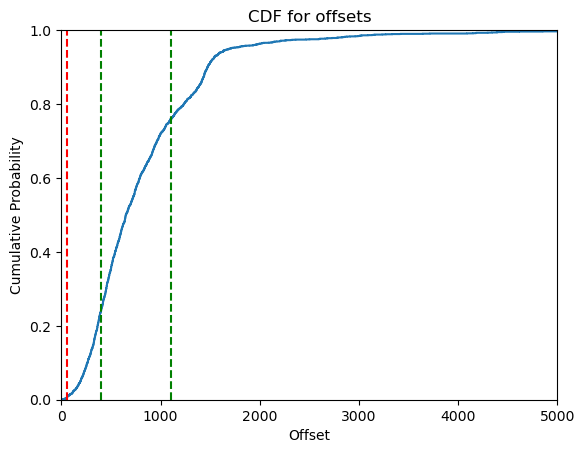

In [21]:
import numpy as np

# the cdf show a steep increase between the green lines, so the majority of hgb reading seperated by 400-1100 mins
# the red line shows distribution of hgb readings with a difference of 60mins, which a low fraction

sns.ecdfplot(time_diff)
plt.xlim(0, 5000)

plt.axvline(60, color='red', linestyle='--')
plt.axvline(400, color='green', linestyle='--')
plt.axvline(1100, color='green', linestyle='--')
plt.xlabel('Offset')
plt.ylabel('Cumulative Probability')
plt.title('CDF for offsets')
plt.show()

In [22]:
# This functions plots a graph with two lines. For every transfusion taken, a point is plotted to show Hgb value at the latest time before
# the infusion, and the earliest time after the transfusion

# this might be used instead if looking at a fixed window size

ids=transfusion_df['patientunitstayid']
def graph_hb(x):
    id=ids[x]
    # hgb readings for patient
    hgb_read=hgb_df[hgb_df['patientunitstayid']==id]
    # transfusions for patient
    transfusion=transfusion_df[transfusion_df['patientunitstayid']==id]
    transfusion_offset=transfusion.offset.unique()
    
    start = transfusion_offset.min()
    stop = transfusion_offset.max()
    
    num_values = int(hgb_read.shape[0] * 0.6)
    inc = np.linspace(start, stop, num=num_values + 2)[1:-1]
    
    transfusion=transfusion.sort_values(by=['offset'])
    # bl_patietransfusionnt
    hgb_read=hgb_read.sort_values(by=['offset'])
    hgb_read['offset'] = hgb_read['offset'].astype(float)
    hgb_read
    
    hb_before = []
    hb_after = []
    
    def find_nearest_indices(times, time):
      before_idx = np.searchsorted(times, time, side='right') - 1
      after_idx = before_idx + 1
      return before_idx, after_idx
    
    for transfusion_time in inc:
      before_idx, after_idx = find_nearest_indices(hgb_read['offset'].values, transfusion_time)
    
      if before_idx >= 0:
          hb_before.append(hgb_read.iloc[before_idx]['value'])
      else:
          hb_before.append(np.nan)
    
      if after_idx < len(hgb_read):
          hb_after.append(hgb_read.iloc[after_idx]['value'])
      else:
          hb_after.append(np.nan)
    
    hb_before = np.array(hb_before)
    hb_after = np.array(hb_after)
    
    print("Hemoglobin before transfusion:", hb_before)
    print("Hemoglobin after transfusion:", hb_after)
    
    plt.plot(inc*1/(60*24),hb_before, label='before infusion', marker='o')
    plt.plot(inc*1/(60*24),hb_after, label='after infusion', marker='o')
    plt.xlabel('Transfusion Offset (days)')
    plt.ylabel('Hemoglobin Value (g/dL)')
    m=ids[x]
    plt.title(f'Hemoglobin Value Before/After Blood Infusion; ID:{m}')
    plt.legend()
    plt.show()

Hemoglobin before transfusion: [7.4 8.5 7.5 7.5 8.2 8.2 9.3 9.3 8.6 8.6 8.  8.  8.9 8.9 8.7 9.1 9.1 9.2
 9.2 9.1 9.1 8.6 8.6 8.7 8.7 8.4 8.4 8.1 8.1 7.9 8.2 8.2 8.  7.5]
Hemoglobin after transfusion: [8.5 7.5 8.2 8.2 9.3 9.3 8.6 8.6 8.  8.  8.9 8.9 8.7 8.7 9.1 9.2 9.2 9.1
 9.1 8.6 8.6 8.7 8.7 8.4 8.4 8.1 8.1 7.9 7.9 8.2 8.  8.  7.5 6.8]


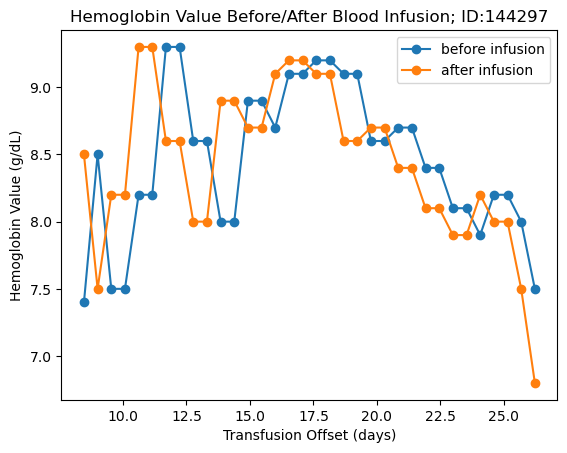

In [23]:
graph_hb(343)